**Задача 1**

Проведите инстанс-сегментацию объектов на изображениях из датасета PennFudanPed https://drive.google.com/drive/folders/1Rs9LY7PQtFVsK0mlr-BV5pvsNIofBDTo?usp=sharing

**Задача 2**

На основе задачи 1:

- Визуализируйте примеры из датасета так, чтоб были видны как маски так и bounding box-ы.
- Добавьте в getitem() подсчет количества объектов на изображении и включите эту информацию в target

In [1]:
%pip install -qU torch_snippets==0.5
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/engine.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/utils.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/transforms.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_eval.py
!wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_utils.py
%pip install -q -U 'git+https://github.com/sizhky/cocoapi.git@patch-1#subdirectory=PythonAPI'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 81.7 MB/s eta 0:00:00
  Preparing

In [2]:
import zipfile

import os
import numpy as np
from PIL import Image
import torch as th
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms.v2 as T

from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import matplotlib.pyplot as plt
import matplotlib.patches as patches

device = 'cuda' if th.cuda.is_available() else 'cpu'

In [3]:
with zipfile.ZipFile('PennFudanPed.zip', 'r') as archive:
    archive.extractall()

In [4]:
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        img_dir = os.path.join(root, "PNGImages")
        mask_dir = os.path.join(root, "PedMasks")

        self.imgs = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
        self.masks = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")

        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        mask = Image.open(mask_path)
        mask = np.array(mask)

        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids != 0]
        num_objects = th.tensor([len(obj_ids)])

        masks = mask == obj_ids[:, None, None]
        masks = th.as_tensor(masks, dtype=th.uint8)

        boxes = []
        for m in masks:
            pos = th.where(m)
            ymin = th.min(pos[0])
            ymax = th.max(pos[0])
            xmin = th.min(pos[1])
            xmax = th.max(pos[1])
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = th.as_tensor(boxes, dtype=th.float32)

        labels = th.ones((len(obj_ids),), dtype=th.int64)

        image_id = th.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = th.zeros((len(obj_ids),), dtype=th.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
            "num_objects": num_objects
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

In [5]:
transform = T.Compose([
    T.PILToTensor(),
    T.ConvertImageDtype(th.float32)
])

dataset = PennFudanDataset('PennFudanPed', transforms=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_ds, test_ds = random_split(
    dataset,
    [train_size, val_size],
    generator=th.Generator().manual_seed(42)
)

data_loader = DataLoader(
    train_ds, batch_size=4, shuffle=True, num_workers=0,
    collate_fn=lambda x: tuple(zip(*x)))

data_loader_test = DataLoader(
    test_ds, batch_size=4, shuffle=False, num_workers=0,
    collate_fn=lambda x: tuple(zip(*x)))

In [6]:
def get_model_instance_segmentation(num_classes):
    model = maskrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [7]:
model = get_model_instance_segmentation(2).to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = th.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 91.7MB/s]


In [8]:
num_epochs = 5

trn_history = []
for epoch in range(num_epochs):
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    lr_scheduler.step()
    res = evaluate(model, data_loader_test, device=device)

/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/34]  eta: 0:01:49  lr: 0.000156  loss: 4.0120 (4.0120)  loss_classifier: 0.7106 (0.7106)  loss_box_reg: 0.3113 (0.3113)  loss_mask: 2.9717 (2.9717)  loss_objectness: 0.0112 (0.0112)  loss_rpn_box_reg: 0.0073 (0.0073)  time: 3.2339  data: 0.0884  max mem: 4918
Epoch: [0]  [10/34]  eta: 0:00:33  lr: 0.001670  loss: 1.4655 (1.9846)  loss_classifier: 0.3185 (0.4107)  loss_box_reg: 0.2154 (0.2550)  loss_mask: 0.7795 (1.2988)  loss_objectness: 0.0142 (0.0148)  loss_rpn_box_reg: 0.0041 (0.0054)  time: 1.3764  data: 0.0652  max mem: 5331
Epoch: [0]  [20/34]  eta: 0:00:18  lr: 0.003184  loss: 0.8402 (1.3835)  loss_classifier: 0.2077 (0.2930)  loss_box_reg: 0.2361 (0.2613)  loss_mask: 0.3326 (0.8094)  loss_objectness: 0.0130 (0.0137)  loss_rpn_box_reg: 0.0054 (0.0061)  time: 1.2365  data: 0.0593  max mem: 6007
Epoch: [0]  [30/34]  eta: 0:00:05  lr: 0.004697  loss: 0.6163 (1.1142)  loss_classifier: 0.0981 (0.2263)  loss_box_reg: 0.2566 (0.2550)  loss_mask: 0.2349 (0.6131)  loss_ob

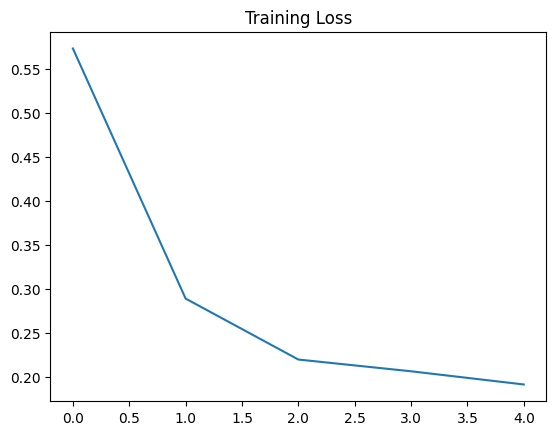

In [9]:
plt.title('Training Loss')
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)
plt.show()

In [10]:
def visualize_sample(sample):
    img, target = sample
    img = img.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)

    boxes = target["boxes"]
    for box in boxes:
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle(
            (xmin, ymin), xmax-xmin, ymax-ymin,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

    masks = target["masks"]
    for mask in masks:
        ax.imshow(mask.numpy(), alpha=0.3, cmap='viridis')

    ax.axis('off')
    plt.tight_layout()
    plt.show()

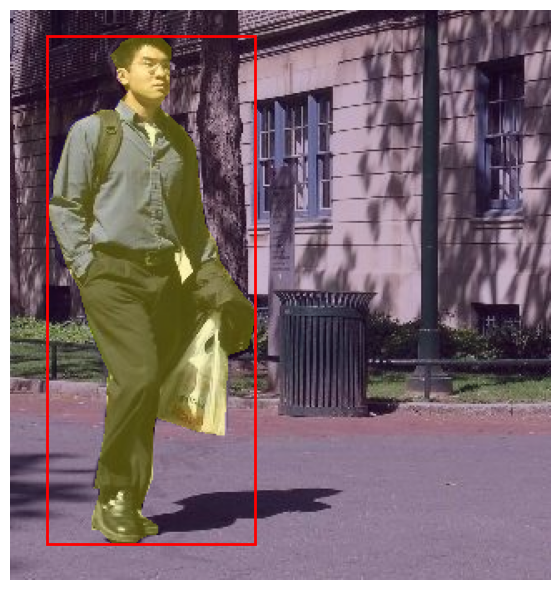

In [11]:
visualize_sample(test_ds[0])

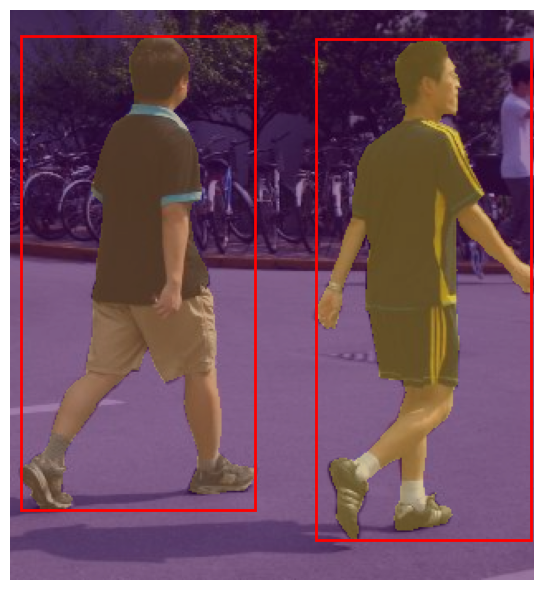

In [12]:
visualize_sample(test_ds[4])